# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

The goal is to train a Decision Tree regression on the engineering data to see which feature determines the resultant electrical capacity of an electrode, and by how much.
The summary of how I do this is:
- Assign an index that indicates the factor that gives us the highest probability in determining the electrical capacity of an electrode.
- Split the data using that chosen factor.
- Repeat process on the condition of the chosen factor until we reach maximum depth or a pure node.

I first read the training data and split it into the values of the features, `X_train`, and the values of the target, `y_train`.

In [2]:
# Reading sample and test data
electrodes_sample = pd.read_csv('nanoelectrodes_capacitance_samples.csv')
electrodes_test = pd.read_csv('nanoelectrodes_capacitance_test.csv')

#Separating training and test data to its target and features
y_train = electrodes_sample['Capacitance ($\mu F / cm^2$)'].astype(int)
X_train = electrodes_sample.iloc[:, list(range(6)) + list(range(7,13))]

y_test = electrodes_test['Capacitance ($\mu F / cm^2$)'].astype(int)
X_test = electrodes_test.iloc[:, list(range(6)) + list(range(7,13))]

# Helps clarify if the data in each feature is categorical or numerical i.e. discrete or continuous.
columns_dict = {index: False for index in range(X_train.shape[1])}


The aforementioned index will be the gini index defined to be:
$$ 
\text{GI}(\boldsymbol y) = 1 - \sum_{i=1}^Q \mathbb P (y = c_i)^2
$$
where $c_i$ is the i-th node out of $Q$ distinct nodes, so $\mathbb P (y = c_i)$ reads the weight of the node $i$ in the current sample $\boldsymbol y$. 



In [3]:
def gini_index(y, sample_weights):
    """
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the GINI-index for y.
    """

    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    # The normalization constant
    total_weight = sum(label_weights.values()) 

    sum_p_squared = 0
    for weight in label_weights.values():
        sum_p_squared += (weight / total_weight)**2  

    # Return GINI-Index
    return 1 - sum_p_squared 

Since all of our training data is numeric, the following three functions defined are dedicatied on splitting the data based on a value that minimises the average weighted total of the gini indices, which is defined to be:

$$GI(\boldsymbol y; j, s) = p_l \times GI(\boldsymbol y_l) + p_r \times GI(\boldsymbol y_r)$$

where $p_l$ and $p_r$ are, respectively, the cumulative weights of samples on the left and on the right. The variables $\boldsymbol y, j$ and $s$ represent `y`, `split_column` and `value` respectively.

In [4]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case `column` is categorical, or
      2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array, np.array): tuple of the left split data (X_l, y_l, w_l).
        tuple(np.array, np.array, np.array): tuple of the right split data (X_l, y_l, w_l)
    """

    if categorical:
        left_mask = (X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, we split X, y, and sample_weights.
    X_l, y_l, w_l = X[left_mask, :], y[left_mask], sample_weights[left_mask] 
    X_r, y_r, w_r = X[~left_mask, :], y[~left_mask], sample_weights[~left_mask] 

    return (X_l, y_l, w_l), (X_r, y_r, w_r)

In [5]:
# Picking the best column based on the value of 'value' that minises the Gini Index
def gini_split_value(X, y, sample_weights, column, categorical):
    """
    Calculates the GINI-index based on `column` with the split that minimizes the GINI-index.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted GINI-index and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    gini_index_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l, w_l), (X_r, y_r, w_r) = split_samples(X, y, sample_weights, column, value, categorical) 

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * gini_index(y_l, w_l) + p_right * gini_index(y_r, w_r) 
        if new_cost < gini_index_val:
              gini_index_val, threshold = new_cost, value

    return gini_index_val, threshold


In [6]:
def gini_split(X, y, sample_weights, columns_dict):
    """
    Chooses the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_gini_index = np.inf
    split_column = None
    split_val = np.nan

    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        gini_index, current_split_val = gini_split_value(X, y, sample_weights, column, categorical)  


        if gini_index < min_gini_index: 
            # Keep track with:

            # 1. the current minimum gini-index value,
            min_gini_index = gini_index 

            # 2. corresponding column,
            split_column = column 

            # 3. corresponding split threshold.
            split_val = current_split_val 

    return split_column, split_val


The function `majority_vote` is added to ensure we cover all cases where the split doesn't/can't happen. It is done by simply taking the mode of the training target based on the weighting of each component $y_i$ in `y_train` .

In [7]:
def majority_vote(y, sample_weights):
    """
    Args:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (int): the majority number
    """
    majority_num = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_num[yi] += wi

    num_prediction = max(majority_num, key=majority_num.get) 

    return num_prediction

The function `build_tree` completes the algorithm on determining the how each node will be chosen.

In [8]:
def build_tree(X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=2):
    """
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training target values, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_num': For leaf nodes, this stores the dominant number. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) all values are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'majority_num': majority_vote(y, sample_weights)}

    split_index, split_val = gini_split(X, y, sample_weights, columns_dict)  

    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'majority_num': majority_vote(y, sample_weights)}

    categorical = columns_dict[split_index]

    # Split samples (X, y, sample_weights) given column, split-value, and categorical flag.
    (X_l, y_l, w_l), (X_r, y_r, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) 
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_num': None,
        'left': build_tree(X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

Putting everything together leads us to `train` where `train` builds the entire tree based on the training data.

In [9]:
def train(X, y,  columns_dict, sample_weights=None):
    """
    Builds the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training target values, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree(X, y, sample_weights, columns_dict, feature_names, depth=1)

In [10]:
# Output of the Decision Tree 
tree = train(X_train, y_train, columns_dict)
tree

{'feature_name': 'H9_Factor ($mL/g$)',
 'feature_index': 7,
 'value': 4.997162405405753,
 'categorical': False,
 'majority_num': None,
 'left': {'feature_name': 'H9_Factor ($mL/g$)',
  'feature_index': 7,
  'value': 4.27729631685984,
  'categorical': False,
  'majority_num': None,
  'left': {'majority_num': 220},
  'right': {'majority_num': 203}},
 'right': {'feature_name': 'Doped_Carbon_Percentage',
  'feature_index': 11,
  'value': 19.76098089518472,
  'categorical': False,
  'majority_num': None,
  'left': {'feature_name': 'Doped_Zinc_Percentage',
   'feature_index': 9,
   'value': 83.80132235741195,
   'categorical': False,
   'majority_num': None,
   'left': {'feature_name': 'Doped_Oxygen_Percentage',
    'feature_index': 3,
    'value': 9.36,
    'categorical': False,
    'majority_num': None,
    'left': {'feature_name': 'Surface_Area ($m^2/g$)',
     'feature_index': 0,
     'value': 410.2,
     'categorical': False,
     'majority_num': None,
     'left': {'feature_name': 'Dop

The following two functions, namely `classify` and `predict`, will allow us to predict values for the resultant electrical capacity using the test data on the features, which is represented by `X_test`.

In [11]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['majority_num'] is not None:
        return tree['majority_num']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)

    else:

        if x[tree['feature_index']] < tree['value']: 
            # go to left branch
            return classify(tree['left'], x)  
        else:
            # go to right branch
            return classify(tree['right'], x)  

In [12]:
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

We now compare the predicted values, `y_pred`, with the true data, `y_test` using the mean squared error:

$$MSE = \mathbb{E}[(y_{train} - y_{test})^2]$$ 

and the coefficient of determination:

$$R^2 = 1 - \frac{ \sum^N_{i=1}{(y_{test_i} - \bar{y}_{test})^2} }{ \sum^N_{i=1}{(y_{test_i} - y_{pred_i})^2} }$$

In [13]:
def MSE(yhat, y):
    return np.mean((yhat - y)**2)

def r_squared(y_pred, y):
    s_1 = sum((y_test - np.mean(y_test))**2)
    s_2 = sum((y_pred - y_test)**2)

    return 1 - s_2/s_1

In [14]:
y_pred = predict(tree, X_test.to_numpy())
print(f'MSE: {MSE(y_pred, y_test)}')
print(f'R^2: {r_squared(y_pred, y_test)}')
print(f'bias: {np.mean(y_pred - y_test)}')
print(f'var: {MSE(y_pred, y_test) - np.mean(y_pred - y_test)**2}')

MSE: 8145.322580645161
R^2: -0.2326751742009936
bias: -29.161290322580644
var: 7294.941727367325


Large $MSE$, negative $R^2$, relatively low bias implies that the variance in the residuals is very large, so the model constructed is perhaps overfitted and has very low predictive power or the model itself is not great for this data. This can be remedied by reducing the value of `max_depth` or simply choosing another model to train.

<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

To construct a Random Forest on the data, the procedure is similar to constructing a Decision Tree however we take an aggregate of many, but smaller, Decision Trees using randomly selected features in the dataset.

Therefore the variables that need to be taken into consideration now are:
- The number of features choses.
- The number of Decision Trees built.

Certain functions need to be modified in order to achieve this. 

The first being the function `gini_split_rf`, as it is similar to the function `gini_split`, however it picks the best feature and best condition to split the feature on by only using the randomly selected features chosen.

In [15]:
def gini_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Chooses the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized gini-index, the best feature index and value used in splitting.
    """

    # The added sampling step.
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_gini_index, split_column, split_val = np.inf, 0, 0

    # Only scans through the sampled columns in `columns_dict`.
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # searchs for the best splitting value for the given column.
        gini_index, val = gini_split_value(X, y, sample_weights, column, categorical)  
        if gini_index < min_gini_index:
            min_gini_index, split_column, split_val = gini_index, column, val

    return min_gini_index, split_column, split_val

Now, the function `build_tree` needs to be modified to call `gini_split_rf` instead.

In [16]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=6, min_samples_leaf=5):
    """Builds the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_num': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # includes a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'majority_num': majority_vote(y, sample_weights)}

    else:
        GI, split_column, split_val = gini_split_rf(n_features, X, y, sample_weights, columns_dict)  

        # If GI is infinity, it means that samples are not seperable by the sampled features.
        if GI == np.inf:
            return {'majority_num': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_column]
        (X_l, y_l, w_l), (X_r, y_r, w_r) = split_samples(X, y, sample_weights, split_column, split_val, categorical) 
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'categorical': categorical,
            'majority_num': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

The function `train_rf` now builds multiple Decision Trees using the randomly selected subset of features.


In [17]:
def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None, max_depth = 6, min_samples_leaf = 5):
    """
    Builds the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Samples the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample,
                             columns_dict, feature_names, depth=1, max_depth= max_depth, min_samples_leaf= min_samples_leaf)
        trees.append(tree)

    return trees

The function `predict_rf` takes the Random Forest constructed and the data of the features and outputs the class with the highest probability.
It does this by taking the average of all predictions made.

In [18]:
def predict_rf(rf, X):
    """
    Predicts classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        """
        This function takes a list of predicted values produced by a list
        of decision trees and returns the average of those values.
        """
        return np.mean(decisions)
    
    if len(X.shape) == 1:
        # if we have one sample
        return aggregate([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([aggregate([classify(tree, x) for tree in rf]) for index, x in X.iterrows()])

The following function performs the 5-fold cross-validation on the model and outputs the average $MSE$ of the Random Forest for every value of $B$ inputted. The value chosen for the number of features is $\approx \frac{p}{3}$ where $p$ = the number of features in the dataset.

In [19]:
def cross_validation_score(X_train, y_train, folds, B):
  scores = []
  p = X_train.shape[1]
  # Iterating over each fold
  for val_indexes in folds:
    val_indexes = list(val_indexes)
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    # Establishing the training data for the cross-validation
    X_train_i = X_train.iloc[train_indexes]
    y_train_i = y_train[train_indexes]

    # Establishing the testing data for the cross-validation
    X_val_i = X_train.iloc[val_indexes]
    y_val_i = y_train[val_indexes] 

    #Training model and error in its prediction of y_val_i using MSE
    rf = train_rf(B, round(p/3), X_train_i, y_train_i, columns_dict)
    y_hat_i = predict_rf(rf, X_val_i)

    score_i = MSE(y_hat_i, y_val_i)
    scores.append(score_i)

  # Returns the average MSE
  return sum(scores) / len(scores) 


In [20]:
# Finding the error between the model prediction and the actual values of y_test over a range of values of B
def choose_best_B(X_train, y_train, folds, B_range):
  B_scores = np.zeros((len(B_range),))

  for i, B in enumerate(B_range):
    B_scores[i] = cross_validation_score(X_train, y_train, folds, B)
    print(f'MSE@k={B}: {B_scores[i]}')

  best_k_index = np.argmin(B_scores)
  return B_range[best_k_index]

In [21]:
# Splitting the training data in 5 to perform 5-fold cross-validation to find best value of B
folds_indexes = np.array_split(np.arange(len(y_train)), 5)
best_B = choose_best_B(X_train, y_train, folds_indexes, np.array([25]))

print('best_k:', best_B)

MSE@k=25: 6743.224358764479
best_k: 25


Turns out the best value of $B$ is $25$ out of checking values from $1$ to $30$. I say this here as the computation ran for over an hour and yes I waited. At least it wasn't 2 hours.
The $MSE$ at $B = 25$ is `6802.21407009009` which is a significant improvement over using the Decision Tree.

In [22]:
# Picking p/3 as an approximate for the number of features to choose
p = round(X_train.shape[1]/3)

# Predicting values of y_test and finding the error by using MSE
rf = train_rf(25, p, X_train, y_train, columns_dict)
y_pred = predict_rf(rf, X_test)
r_squared(y_pred, y_test)

-0.008790298790450901

It seems that the value of $R^2$ at $B= 25$ decreased in magnitude slightly, when comparing it to the Decision Tree, suggesting that the covariance between `y_pred` and `y_test` indeed decrease which is consistent with the findings of the $MSE$.

In [23]:
# Picking an arbitrary fold to find a tree in the ensemble of B Decision Trees
val_indexes = folds_indexes[1]
train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

# Establishing the training data for the cross-validation
X_train_i = X_train.iloc[train_indexes]
y_train_i = y_train[train_indexes]

# Establishing the testing data for the cross-validation
X_val_i = X_train.iloc[val_indexes]
y_val_i = y_train[val_indexes] 

# Training model and predicting values of 
rf_sub = train_rf(25, round(p/3), X_train_i, y_train_i, columns_dict)
y_hat_i = predict_rf(rf, X_val_i)

MSE(y_hat_i, y_val_i)

5690.404257142857

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)

In [24]:
def cv_score_depth_leaf(X_train, y_train, folds, B, max_depth, min_samples_leaf):
  scores = []
  p = X_train.shape[1]
  # Iterating over each fold
  for val_indexes in folds:
    val_indexes = list(val_indexes)
    train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
    
    # Establishing the training data for the cross-validation
    X_train_i = X_train.iloc[train_indexes]
    y_train_i = y_train[train_indexes]

    # Establishing the testing data for the cross-validation
    X_val_i = X_train.iloc[val_indexes]
    y_val_i = y_train[val_indexes] 

    #Training model and error in its prediction of y_val_i using MSE
    rf = train_rf(B, round(p/3), X_train_i, y_train_i, columns_dict, max_depth= max_depth, min_samples_leaf= min_samples_leaf)
    y_hat_i = predict_rf(rf, X_val_i)

    score_i = MSE(y_hat_i, y_val_i)
    scores.append(score_i)

  # Returns the average MSE
  return sum(scores) / len(scores) 

In [25]:
# Finding the error between the model prediction and the actual values of y_test over a range of values of B

def best_depth_leaf(X_train, y_train, folds, max_depth_range, min_samples_leaf_range):
  depth_leaf_scores = np.zeros((len(max_depth_range), len(min_samples_leaf_range)))

  for i, max_depth in enumerate(max_depth_range):
    for j, min_samples_leaf in enumerate(min_samples_leaf_range):
        depth_leaf_scores[i, j] = cv_score_depth_leaf(X_train, y_train, folds, 25, max_depth = max_depth , min_samples_leaf = min_samples_leaf)

  min_array_index = np.argmin(depth_leaf_scores)
  min_index_ij = np.unravel_index(min_array_index, depth_leaf_scores.shape)
  return max_depth_range[min_index_ij[0]], min_samples_leaf_range[min_index_ij[1]]

In [26]:
best_depth_leaf(X_train, y_train, folds_indexes, np.arange(1,5), np.arange(1,5))

(4, 4)



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

Starting with the construction of the network, I assume that each layer is fully connected with one another.

In [27]:
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X]) 
    return a

Now we need to define the activation function for the model, which will be: 
$$ \sigma(x) = tan^{-1}(x)ln(|x| + 1) $$

In [28]:
def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # computes post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h

The gradient of the activation function will be needed later for running 300 epochs of the MLP. Which will be:

$$ \sigma'(x) = \frac{ln(|x|+1)}{x^2 + 1} + sgn(x)\frac{tan^{-1}(x)}{|x| + 1}$$

where, 

\begin{equation*}
sgn(x) = \begin{cases}
1 & \quad x \ge 0, \\
-1 & \quad x < 0.
\end{cases}
\end{equation*}

In [29]:
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # computes gradient
    grad = np.log(np.abs(a) + 1)/(1 + a**2) + np.arctan(a)*np.sign(a)/(np.abs(a) + 1) 
    return grad

The dictionary `activation_table` will be used as a reference in the class `MLP` to know which activation function to use in each layer.

The class `MLP` will be how the 3-layer perceptron will be defined.

In [30]:
activation_table = {
    "relu": relu_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), 
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]] 
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)}) 

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) 
        # predicted target is output of last layer
        return y_hat, forward_pass

The loss function will be the mean squared error defined as:
$$ \mathcal{l}(\hat{\boldsymbol{y}}, \boldsymbol{y}) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y}_i - y_i)^2, $$
where $\hat{\boldsymbol{y}}$ is the vector of fitted values, $\boldsymbol{y}$ is the vector of true values and $n$ is the dimension of the vector.

In our case, the inputs will be one-dimensional.

In [31]:
def mse_loss(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)


    return np.mean((y_true - y_pred)**2, keepdims=True) 

We also need 
$$\nabla_{\hat{\boldsymbol{y}}}\mathcal{l}(\hat{\boldsymbol{y}}, \boldsymbol{y}) = \frac{2}{n}(\hat{\boldsymbol{y}} - \boldsymbol{y})$$

In [32]:
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size 

We also need to define the backpropagation algorithm to complete the stochastic gradient descent algorithm on the MLP.

In [33]:
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$. The

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h, 
                          "b" : delta.sum(axis=0)}) 

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) 


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

Need to implement the algorithm for the SGD step for a mini-batch.

In [34]:
def sgd_step(X, y, mlp, learning_rate = 1e-3):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) 

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output) 

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

Will use the value of $R^2$ (along with the loss function) to determine performance of the model on the MLP.

In [35]:
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

Now we can put together everything to train the parameters of the MLP model using SGD.

In [36]:
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate)

            # update weights and biases of MLP
            mlp.layers = updated_layers 

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test


Best to standardise the training data before applying and training the model.
This is because of the SGD step of subtracting the gradient of the loss function.

If the training data is unstandardised, then teh value of each component of the loss function gradient may contain values of significantly different magnitudes, leading to a disproportionate result at certain axes of the updated parameter.

In [37]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True) 
    sigma = np.std(X_train_, axis=0, keepdims=True) 
    X_std = (X - mu) / sigma 
    return X_std

Now we train the model on the training data and test it on the testing data.

In [38]:
mlp = MLP(seed=2)
mlp.add_layer(X_train.shape[1], 50)
mlp.add_layer(50, 50, "relu")
mlp.add_layer(50, 50, "relu")
mlp.add_layer(50, 1, "relu")
print("Number of layers:",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

Z_train = standardise(X_train.to_numpy())
Z_test = standardise(X_test.to_numpy())

u_train = standardise(y_train.to_numpy())
u_test = standardise(y_test.to_numpy())

n_epochs = 300
mlp, losses_train, losses_test = sgd(Z_train, u_train, Z_test, u_test,
                                     mlp, learning_rate = 5e-5,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 4
Number of trainable parameters: 5801


  0%|          | 0/300 [00:00<?, ?it/s]

We now plot the losses at each front and back propagation.

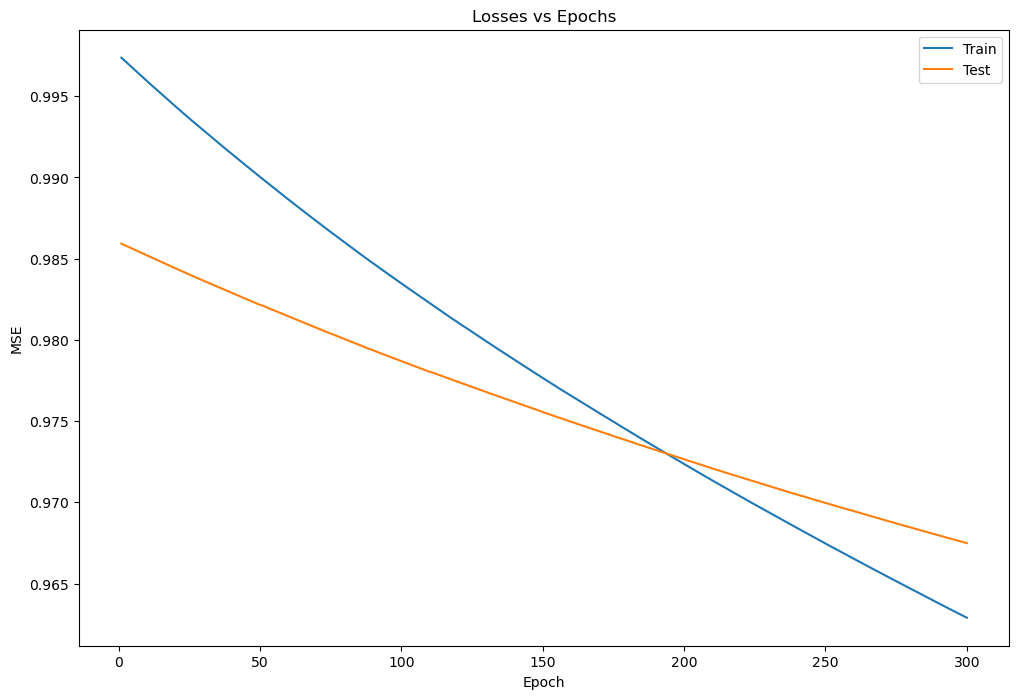

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

As expected, the model becomes slightly more accurate for higher epochs, and you would also expect that the model would better fit the training data.

It seems that the losses (mean squared error) converge to 0 for both lines which is what we want but it seems it would take a very long time for both lines, especially for the testing data, to reach 0.

The training $R^2$ and the $R^2$ are not only similar but also very small. This is interesting but it perhaps might be to do with the size of the mini-batches. The greater the size, the closer it becomes to Batch Gradient Descent meaning that the value of $R^2$ for both types of data would be higher but with slower convergence.

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

To apply SDG with momentum we only need to make a few changes to certain functions, specifically `sdg_step` and `sdg`.

In [40]:
def sgd_mm_step(X, y, mlp, learning_rate = 1e-3, momentum = 0.4):
    """
    Apply a stochastic gradient descent with momentum step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) 

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat)
    
    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output) 
    
    # Initialise the velocities for the algorithm.
    v_t_dict = [{'W': np.zeros_like(layer['W']), 'b': np.zeros_like(layer['b'])} for layer in mlp.layers]
   
    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for v_t, layer, grad in zip(v_t_dict, mlp.layers, gradients):
        v_t['W'] = momentum * v_t['W'] + learning_rate * grad['W']
        v_t['b'] = momentum * v_t['b'] + learning_rate * grad['b']
        W = layer["W"] - v_t['W'] 
        b = layer["b"] - v_t['b'] 
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

In [41]:
def sgd_mm(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3, momentum_rate = 0.4,
        n_epochs=10, minibatchsize=1, seed=42):
    """
    Run the Stochastic Gradient Descent with Momentum (SGDM) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        momentum_rate (float): The momentum_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgdm step
            updated_layers = sgd_mm_step(X_batch, y_batch, mlp, learning_rate, momentum_rate) 

            # update weights and biases of MLP
            mlp.layers = updated_layers 

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test


Now we train the model.

In [42]:
mlp = MLP(seed=2)
mlp.add_layer(X_train.shape[1], 50)
mlp.add_layer(50, 50, "relu")
mlp.add_layer(50, 50, "relu")
mlp.add_layer(50, 1, "relu")
print("Number of layers:",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

Z_train = standardise(X_train.to_numpy())
Z_test = standardise(X_test.to_numpy())

u_train = standardise(y_train.to_numpy())
u_test = standardise(y_test.to_numpy())

n_epochs = 300
mlp, losses_train_mom, losses_test_mom = sgd_mm(Z_train, u_train, Z_test, u_test,
                                     mlp, learning_rate = 5e-5, momentum_rate=0.4,
                                     n_epochs=n_epochs,
                                     minibatchsize=8)

Number of layers: 4
Number of trainable parameters: 5801


  0%|          | 0/300 [00:00<?, ?it/s]

And then we plot the MSE for each model to compare their performance.

True


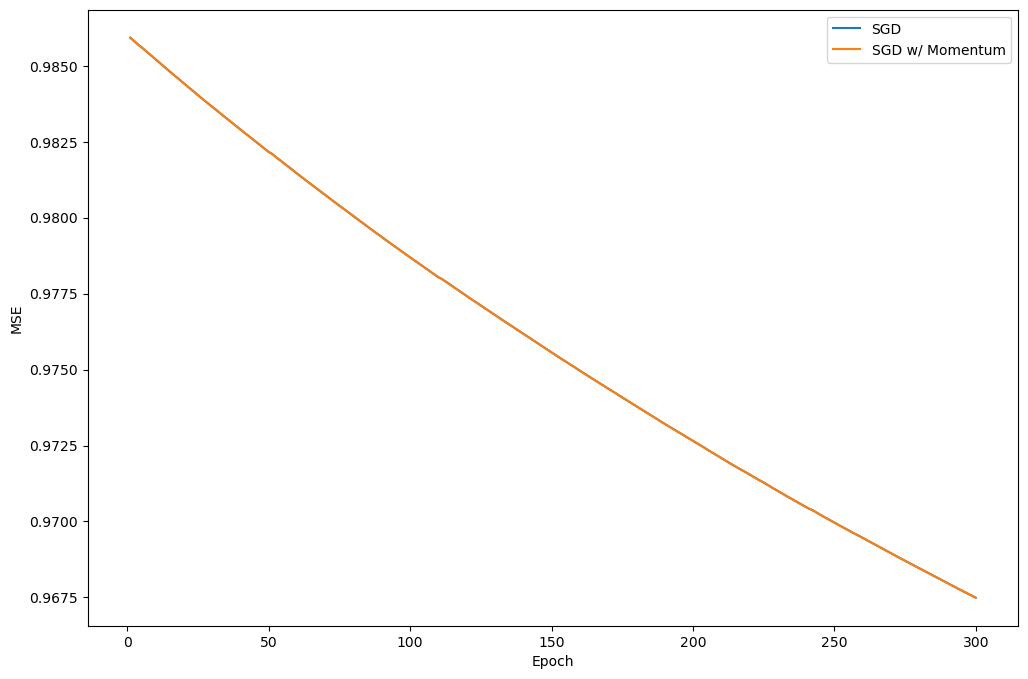

In [43]:
print(losses_test == losses_test_mom)
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(np.arange(1,n_epochs+1),losses_test, label="Random Forest")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="SGD")
ax.plot(np.arange(1,n_epochs+1),losses_test_mom, label="SGD w/ Momentum")
ax.set(xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)

To apply the linear model to the quadratic basis of features we first need to create the matrix of interaction features which I will refer to as `X_prime_train`.

In [44]:
def add_interaction_terms(X):
    """
        Input:
            X: an nxm np matrix with columns representing the features
        Returns:
            X': a matrix of interaction terms/features as columns
    """
    X_t_prime = []
    X_t_list = X.T.tolist()
    
    for row_i in X_t_list:
        for row_j in X_t_list:
            X_t_prime.append(np.array(row_i) * np.array(row_j))
            
    return np.array(X_t_prime).T

In [45]:
X_prime_train = add_interaction_terms(X_train.to_numpy())

Now it's time to add functions that will determine the coefficients for the ridge regression linear model, $\boldsymbol\beta^{*}_{\text{ridge}}$ which will be defined as:
$$ \boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I)^{-1}\boldsymbol X^T\boldsymbol y \, . $$
where $\lambda$ will the penalty term.

In [46]:
def ridge_estimate(X, y, penalty):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    N, D = X.shape
    I = np.identity(D)
    beta_ridge = np.linalg.solve(X.T @ X - penalty * I, X.T @ y)
    return beta_ridge

In [47]:
def predict_with_estimate(X_test, beta):

    # X_test: K x D matrix of test inputs
    # beta: D x 1 vector of parameters
    # returns: prediction of f(X_test); K x 1 vector

    prediction = X_test @ beta 

    return prediction

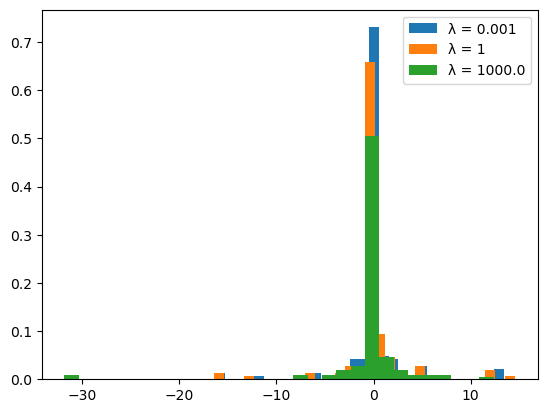

In [48]:
betas = []
predictions = []
penalties = [1e-3, 1, 1e+3]
for penalty in penalties:
    beta_ml = ridge_estimate(X_prime_train, y_train, penalty)
    betas.append(beta_ml)
    prediction = predict_with_estimate(X_prime_train, beta_ml)
    predictions.append(prediction)
    
predictions = np.array(predictions)
for beta, penalty in zip(betas, penalties):
    plt.hist(beta, bins = 30, density = True, label = f'λ = {penalty}')
plt.legend()


$\boldsymbol\beta^{*}_{\text{ridge}}$  seems to Normally distributed for all three values of $\lambda$ as we expected.

It also seems that for each value of $\lambda$, the distribution becomes less concentrated at $0$ as $\lambda$ gets larger. 

Since we assume that $\boldsymbol\beta^{*}_{\text{ridge}}$ is Normally distributed, this implies that larger values in $\lambda$ lead to larger variances in the coefficients of the ridge linear regression.

The variance of $\boldsymbol\beta^{*}_{\text{ridge}}$ is $\sigma^2(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I})^{-1}\boldsymbol{X}^T\boldsymbol{X}(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I})^{-1}$ so for small values of $\lambda$ we would expect:
$$ Var(\boldsymbol\beta^{*}_{\text{ridge}}) \approx \sigma^2 (\boldsymbol{X}^T\boldsymbol{X})^{-1} $$
and for larger values of $\lambda$



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

The goal is to train a kNN classifier of the tumour type, optimise the model and assess its performance.

First we read the data and split it for training

In [49]:
brain_cancer_samples = pd.read_csv('brain_cancer_samples.csv')
brain_cancer_test = pd.read_csv('brain_cancer_test.csv')

class_index = brain_cancer_samples.columns.get_loc('Class')

X_train = brain_cancer_samples.iloc[:, :class_index].to_numpy()
y_train = brain_cancer_samples.iloc[:, class_index].to_numpy()

X_test = brain_cancer_test.iloc[:, :class_index].to_numpy()
y_test = brain_cancer_test.iloc[:, class_index].to_numpy()

Now we construct the function `predict` which will (hopefully) predict the class of each patient in `X_test`. 
Before doing that, we construct the function `euclidian_distance` as a metric, and the `k_neighbours` as the function that carries out the majority of the kNN algorithm.

In [50]:
def euclidian_distance(p, q):
    return np.sqrt(np.sum((p-q)**2, axis=1)) 

In [51]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []

    # computes distance from each point x_test in X_test to all points in X_train 
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test] 

    # determines which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # returns distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

In [52]:
def predict(X_train, y_train, X_test, k=5):
    # each of the k neighbours contributes equally to the classification of any data point in X_test
    neighbours = k_neighbours(X_train, X_test, k=k)
    # counts number of occurences of label with np.bincount and choose the label that has most with np.argmax 
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

Now we see what the predictions are.

In [53]:
y_pred = predict(X_train, y_train, X_test)
y_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

Now we apply the 5-fold cross-validation on the kNN classifier.

Using the `score` function as way of measuring loss, we take the average loss across each fold at a chosen $k$ value.

The `score` function is defined to be $ \frac{1}{n}\sum_{i=1}^{n}{\mathbb{1}(y_{pred_i} = y_{test_i})}$, where $y_{test}, y_{pred} \in \mathbb{R}^n$.

In [54]:
def score(X_train, y_train, X_test, y_test, k=5):
    y_pred = predict(X_train, y_train, X_test, k=k)
    return float(sum(y_pred==y_test))/ float(len(y_test))

In [55]:
def cross_validation_score(X_train, y_train, folds, k):
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]


        X_val_i = X_train[val_indexes, :] 
        y_val_i = y_train[val_indexes] 

        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k) 
        scores.append(score_i)

    # Returns the average score
    return sum(scores) / len(scores) 

In [56]:
def choose_best_k(X_train, y_train, folds, k_range):
    k_scores = np.zeros((len(k_range),))

    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index]

In [57]:
folds_indexes = np.split(np.arange(len(y_train)), 5)

best_k = choose_best_k(X_train, y_train, folds_indexes, np.arange(1, 31))

print('best_k:', best_k)

CV_ACC@k=1: 0.531
CV_ACC@k=2: 0.524
CV_ACC@k=3: 0.531
CV_ACC@k=4: 0.614
CV_ACC@k=5: 0.572
CV_ACC@k=6: 0.593
CV_ACC@k=7: 0.572
CV_ACC@k=8: 0.586
CV_ACC@k=9: 0.510
CV_ACC@k=10: 0.538
CV_ACC@k=11: 0.510
CV_ACC@k=12: 0.517
CV_ACC@k=13: 0.503
CV_ACC@k=14: 0.476
CV_ACC@k=15: 0.490
CV_ACC@k=16: 0.483
CV_ACC@k=17: 0.476
CV_ACC@k=18: 0.490
CV_ACC@k=19: 0.503
CV_ACC@k=20: 0.497
CV_ACC@k=21: 0.497
CV_ACC@k=22: 0.490
CV_ACC@k=23: 0.490
CV_ACC@k=24: 0.517
CV_ACC@k=25: 0.524
CV_ACC@k=26: 0.503
CV_ACC@k=27: 0.490
CV_ACC@k=28: 0.510
CV_ACC@k=29: 0.531
CV_ACC@k=30: 0.524
best_k: 4


We now know the best $k$ is 4 so for the next part let's first redefine `y_pred`.

In [58]:
y_pred = predict(X_train, y_train, X_test, k = 4)
y_pred

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int64)

In [59]:
freq_classes = {0: 0, 1:0, 2:0}
for types in y_pred:
    freq_classes[types] = freq_classes.get(types, 0) + 1
minority_class = min(freq_classes, key = freq_classes.get)
minority_class

2

Now we want to assess the predictions.
Let's first create the confusion matrix.

In [60]:
confusion_matrices = [{} for  i in range(len(freq_classes.keys()))]

for i in freq_classes:
    confusion_matrices[i]['TP'] = confusion_matrices[i].get('TP', 0)
    confusion_matrices[i]['FP'] = confusion_matrices[i].get('FP', 0)
    confusion_matrices[i]['TN'] = confusion_matrices[i].get('TN', 0)
    confusion_matrices[i]['FN'] = confusion_matrices[i].get('FN', 0)
    for prediction, truth in zip(y_pred, y_test):
        if prediction == truth and prediction == i:
            confusion_matrices[i]['TP'] = confusion_matrices[i].get('TP') + 1
            
        elif prediction != truth and prediction == i:
            confusion_matrices[i]['FP'] = confusion_matrices[i].get('FP') + 1
            
        elif prediction == truth and prediction != i:
            confusion_matrices[i]['TN'] = confusion_matrices[i].get('TN') + 1
        
        else:
            confusion_matrices[i]['FN'] = confusion_matrices[i].get('FN') + 1

confusion_matrices

[{'TP': 11, 'FP': 14, 'TN': 22, 'FN': 13},
 {'TP': 20, 'FP': 12, 'TN': 13, 'FN': 15},
 {'TP': 2, 'FP': 1, 'TN': 31, 'FN': 26}]

Below are functions used to define the six metrics.

In [61]:
def accuracy(confusion_matrices, average = 0):
    """
        Input:
            confusion_matrices (list): a list of confusion matrices which are stored as dictionaries
            average (0 or 1): 0 for macro-average accuracy, 1 for micro-average accuracy
            
        Output:
            accuracy (float): macro-average or micro-average accuracy depending on value of average.
    """
    n = len(confusion_matrices)
    
    if average == 0: # for macro-average accuracy
        
        accuracies = []
        
        for i in range(n):
            M = confusion_matrices[i]
            accuracy = (M['TP'] + M['FN']) / (sum(M.values()))
            accuracies.append(accuracy)
            
        return np.mean(accuracy)
    
    if average == 1: # for micro-average accuracy
        
        tp_total = sum([confusion_matrices[i]['TP'] for i in range(n)])
        tn_total = sum([confusion_matrices[i]['TN'] for i in range(n)])
        fp_total = sum([confusion_matrices[i]['FP'] for i in range(n)])
        fn_total = sum([confusion_matrices[i]['FN'] for i in range(n)])
        
        totals = [tp_total, tn_total, fp_total, fn_total]
        
        return (tp_total + tn_total) / sum(totals)
        

In [62]:
def precision(confusion_matrices, average = 0):
    """
        Input:
            confusion_matrices (list): a list of confusion matrices which are stored as dictionaries
            average (0 or 1): 0 for macro-average precision, 1 for micro-average precision
            
        Output:
            accuracy (float): macro-average or micro-average precision depending on value of average.
    """
    
    n = len(confusion_matrices)
    
    if average == 0: # for macro-average precision
        
        precisions = []
        
        for i in range(n):
            M = confusion_matrices[i]
            precision = M['TP'] / (M['TP'] + M['FP'])
            precisions.append(precision)
            
        return np.mean(precisions)
    
    if average == 1: # for micro-average precision
        
        tp_total = sum([confusion_matrices[i]['TP'] for i in range(n)])
        fp_total = sum([confusion_matrices[i]['FP'] for i in range(n)])
        
        return tp_total / (tp_total + fp_total)
    

In [63]:
def class_weighted(confusion_matrices, a_or_p):
    """
        Inputs:
            confusion_matrices (list): a list of confusion matrices which are stored as dictionaries
            a_or_p ('a' or 'p'): picks the type of average: accuracy or precision
        Output:
            class-weighted average precision or accuracy
    """
    
    n = len(confusion_matrices)
    sum_of_classes = sum([sum(confusion_matrices[i].values()) for i in range(n)])
    class_weights = {i: sum(confusion_matrices[i].values()) / sum_of_classes for i in range(n)}
    
    if a_or_p == 'a': # for class-weighted average accuracy
        
        accuracies = []
        
        for i in range(n):
            M = confusion_matrices[i]
            accuracy = (M['TP'] + M['FN']) / (sum(M.values()))
            accuracies.append(accuracy)
            
        weighted_accuracies = [accuracy * class_weight for accuracy, class_weight in zip(accuracies, class_weights.values())]
    
        return np.mean(weighted_accuracies) 

    if a_or_p == 'p': # for class-weighted average accuracy
        
        precisions = []
        
        for i in range(n):
            M = confusion_matrices[i]
            precision = M['TP'] / (M['TP'] + M['FP'])
            precisions.append(precision)
        
        weighted_precisions = [precision * class_weight for precision, class_weight in zip(precisions, class_weights.values())]
        
        return np.mean(weighted_precisions)

In [64]:
print('Macro-average accuracy: ', accuracy(confusion_matrices, 0))
print('Micro-average accuracy: ', accuracy(confusion_matrices, 1))
print('Macro-average precision: ', precision(confusion_matrices, 0))
print('Micro-average precision: ', precision(confusion_matrices, 1))
print('Class-weighted average accuracy: ', class_weighted(confusion_matrices, 'a'))
print('Class-weighted average precision: ', class_weighted(confusion_matrices, 'p'))

Macro-average accuracy:  0.4666666666666667
Micro-average accuracy:  0.55
Macro-average precision:  0.5772222222222222
Micro-average precision:  0.55
Class-weighted average accuracy:  0.16111111111111112
Class-weighted average precision:  0.1924074074074074


The micro-average accuracy is greater than the macro-average accuracy however the macro-average precision is slightly greater than the micro-average precision and the class-weigthed averages is both low, implying that the model does not predict the minority class well.

You can get that from inspection of the confusion matrix. The minority class is class 2. The amount of false negatives were high and the amount of true positive were low.
Additionally, the amount of true negatives were high and amount of false positives were low.

This implies that class 2 had too little significance when training the model, and the model opts for the other classes too often when it should be class 2 that should be opted. 

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

Since the model opts for the other classes too often, the idea is to weight the classes such that the minority class has more of a priority.

I attempt to do this by weighting the classes by $1/p_i$ where $p_i$ is the proportion of class $i$ in the training dataset.

In [65]:
def k_weighted_neighbours(X_train, y_train, X_test, k=5, weight_parameter = 1, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []

    # computes distance from each point x_test in X_test to all points in X_train 
    #point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test] 
    # freq_classes is dictionary that contains the frequency of each class in the training dataset X_train
    freq_classes = {0:0, 1:0, 2:0}
    
    for i, x_test in enumerate(X_test):
        if y_train[i] == 0:
            freq_classes[0] = freq_classes.get(0, 0) + 1
        elif y_train[i] == 1:
            freq_classes[1] = freq_classes.get(1, 0) + 1
        else:
            freq_classes[2] = freq_classes.get(2, 0) + 1
            
    ordered_classes = sorted(freq_classes.items(), key = lambda x: x[1])
    
    for i, (key, value) in enumerate(ordered_classes):
        freq_classes[key] = 10**(len(ordered_classes) - i)
    
    point_dist = [euclidian_distance(x_test, X_train) / (freq_classes[y_train[i]]) for i, x_test in enumerate(X_test)] 
    
    # determines which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # returns distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)

In [66]:
def predict_weighted(X_train, y_train, X_test, k=5):
    # each of the k neighbours contributes equally to the classification of any data point in X_test
    neighbours = k_weighted_neighbours(X_train, y_train, X_test, k=k)
    # counts number of occurences of label with np.bincount and choose the label that has most with np.argmax 
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours]) 

    return y_pred

I show the result below to explain what happens a bit later. When determining the performance of the weighted kNN using the same six metrics used before, I get the exact same values for each metric and the result below shows why.

The attempted implementation of the weighting had no effect.

In [67]:
y_pred_weighted = predict_weighted(X_train, y_train, X_test, k=4)
print(y_pred_weighted == y_pred)
print(y_pred_weighted)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
[0 1 0 1 1 1 0 1 1 1 1 1 1 1 2 1 0 1 1 0 0 0 1 0 0 0 0 2 0 0 2 0 1 0 0 1 0
 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1]


In [68]:
confusion_matrices = [{} for  i in range(len(freq_classes.keys()))]

for i in freq_classes:
    confusion_matrices[i]['TP'] = confusion_matrices[i].get('TP', 0)
    confusion_matrices[i]['FP'] = confusion_matrices[i].get('FP', 0)
    confusion_matrices[i]['TN'] = confusion_matrices[i].get('TN', 0)
    confusion_matrices[i]['FN'] = confusion_matrices[i].get('FN', 0)
    for prediction, truth in zip(y_pred_weighted, y_test):
        if prediction == truth and prediction == i:
            confusion_matrices[i]['TP'] = confusion_matrices[i].get('TP') + 1
            
        elif prediction != truth and prediction == i:
            confusion_matrices[i]['FP'] = confusion_matrices[i].get('FP') + 1
            
        elif prediction == truth and prediction != i:
            confusion_matrices[i]['TN'] = confusion_matrices[i].get('TN') + 1
        
        else:
            confusion_matrices[i]['FN'] = confusion_matrices[i].get('FN') + 1

confusion_matrices

[{'TP': 11, 'FP': 14, 'TN': 22, 'FN': 13},
 {'TP': 20, 'FP': 12, 'TN': 13, 'FN': 15},
 {'TP': 2, 'FP': 1, 'TN': 31, 'FN': 26}]

In [69]:
print('Macro-average accuracy: ', accuracy(confusion_matrices, 0))
print('Micro-average accuracy: ', accuracy(confusion_matrices, 1))
print('Macro-average precision: ', precision(confusion_matrices, 0))
print('Micro-average precision: ', precision(confusion_matrices, 1))
print('Class-weighted average accuracy: ', class_weighted(confusion_matrices, 'a'))
print('Class-weighted average precision: ', class_weighted(confusion_matrices, 'p'))

Macro-average accuracy:  0.4666666666666667
Micro-average accuracy:  0.55
Macro-average precision:  0.5772222222222222
Micro-average precision:  0.55
Class-weighted average accuracy:  0.16111111111111112
Class-weighted average precision:  0.1924074074074074


<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

Need to extract the training and testing data that only belong to either class 1 or class 2.

In [70]:
X_log_train = []
y_log_train = []

for i, x, y in zip(range(len(y_train)), X_train, y_train):
    if y == 1 or y == 2:
        X_log_train.append(x)
        y_log_train.append(y)
       
# the training data for logistic regression
X_log_train = np.array(X_log_train)
y_log_train = np.array(y_log_train)

In [71]:
X_log_test = []
y_log_test = []

for i, x, y in zip(range(len(y_test)), X_test, y_test):
    if y == 1 or y == 2:
        X_log_test.append(x)
        y_log_test.append(y)
    else:
        continue
       
# the training data for logistic regression
X_log_test = np.array(X_log_test)
y_log_test = np.array(y_log_test)

In [72]:
# The sigmoid function
def logistic(z):
    return 1. / (1. + np.exp(-z))

In [73]:
# sigmoid function where the input is the dot product of x with beta plus a constant beta0
def predict_logistic(X, beta0, beta):
    y_logistic = logistic(X @ beta + beta0) 
    return y_logistic.squeeze()

In [74]:
# Used to initialise beta and beta0 both as vector of zeroes.
def initialise(size):
    beta = np.zeros((size, 1))
    return beta

In [75]:
# The function will be used to complete each step in the iteration of the gradient descent algorithm.
def propagate(X, y, beta0, beta, penalty = 2.5e-3):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    y_log = predict_logistic(X, beta0, beta)

    # Mean sample loss function
    k = np.mean(y_log)
    A = np.nan_to_num(np.log(y_log), nan = k, posinf = k, neginf = k)
    B = np.nan_to_num(np.log(1 - y_log), nan = k, posinf = k, neginf = k)
    
    mean_loss = - np.mean(y * A + (1-y) * B) + (penalty/2) * np.sum(beta**2)

    # Derivatives
    dbeta0 = np.mean(y - y_log).reshape(-1, 1)
    dbeta = np.mean(X.T * (y_log - y) + penalty * beta, axis=1).reshape(-1, 1) 
    
    mean_loss = np.squeeze(mean_loss)
  
    # Store gradients in a dictionary
    grads = {'dbeta0': dbeta0, 'dbeta': dbeta}
  
    return grads, mean_loss

In [76]:
# Implements the gradient descent algorithm to calculate the 'best' beta
def optimise(X, y, beta0, beta, num_iterations=1000, learning_rate=0.1, penalty = 2.5e-3 , print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    mean_loss_history = []
    
    for i in range(int(num_iterations)):

        # Calculating the loss and gradients 
        grads, mean_loss = propagate(X, y, beta0, beta, penalty)  
      
        # Retrieving derivatives from grads
        dbeta0 = grads['dbeta0']
        dbeta = grads['dbeta']
      
        # Updating procedure
        beta0 = beta0 - learning_rate * dbeta0
        beta = beta - learning_rate * dbeta  
        
        # Records the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
      
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
  
    # Saving parameters and gradients in dictionary
    params = {'beta0': beta0, 'beta': beta}
    grads = {'dbeta0': dbeta0, 'dbeta': dbeta}
  
    return params, grads, mean_loss_history

In [77]:
# Used to fit model
def predict(X_test, beta0, beta):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta0 = beta.reshape(X_test.shape[0], 1)
    beta = beta.reshape(X_test.shape[1], 1)
    
    # Predicting the probabilities
    y_log = predict_logistic(X_test, beta0, beta)
  
    y_pred = y_log.round().reshape(1, -1) 
  
    return y_pred

In [78]:
# Outputs the full information needed about how well the model fit and its parameters
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.1, penalty = 2.5e-3, print_loss=False):
    # Initialising parameters with zeros
    beta0 = initialise(X_train.shape[0])
    beta = initialise(X_train.shape[1])
    
    # Gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta0, beta, num_iterations, learning_rate, penalty, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']
    beta0 = parameters['beta0']
    
    # Predicting test and training set examples
    y_pred_test = predict(X_test, beta0, beta)
    y_pred_train = predict(X_train, beta0, beta)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta0': beta0, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
  
    return d

In [79]:
d = model(X_log_train, y_log_train, X_log_test, y_log_test, num_iterations=500, learning_rate=0.1, penalty = 2.5e-3, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 22332561.071913
Mean loss after iteration 200: 86043876.816782
Mean loss after iteration 300: 188070729.639234
Mean loss after iteration 400: 325521353.340383


C:\Users\liiba\AppData\Local\Temp\ipykernel_3108\3643047207.py:19: RuntimeWarning: divide by zero encountered in log
  B = np.nan_to_num(np.log(1 - y_log), nan = k, posinf = k, neginf = k)


ValueError: cannot reshape array of size 11 into shape (42,1)

The `nan` values come from the algorithm ran inside the `propagation` function.
It happens specifically when calculating `np.log(y_log)` and `np.log(1 - y_log)`.
This is because if at least one entry, in either one of the matrices, has a value of `inf` or `nan`, the mean loss will take it into the calculation and the output will be `inf` or `nan`.

I attempted to work around this however it resulted in increasing mean loss which should not be happening.

In [80]:
loss_history = np.squeeze(d['mean_loss_history'])
plt.figure(figsize=(12,8))
plt.ylabel('Mean training loss')
plt.xlabel('Iterations (in hundreds)')
plt.title('Learning curve for learning rate = ' + str(d['learning_rate']))
plt.plot(loss_history);

NameError: name 'd' is not defined

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

Under the kernelised version of the logistic regression model from task $\boldsymbol{2.2.1}$, the appropriate loss function will be:
$$
E_z(L) = -\frac{1}{N} \sum_{i=1}^{N} y^{(i)}logh_{\boldsymbol{\beta_z}, \beta_0}(\boldsymbol{z}^{(i)}) + (1 - y^{(i)})log(1 - h_{\boldsymbol{\beta_z}, \beta_0}(\boldsymbol{z}^{(i)})) + \frac{1}{2}||\boldsymbol{\beta_z}||^2
$$
where
$$
\begin{align*}
\boldsymbol{z}^{(i)} &= \phi(\boldsymbol{x^{(i)}}) \\
\boldsymbol{\beta_{z}} &= \phi(\boldsymbol{\beta}) \\
\end{align*}
$$

and $\phi$ is a function such that $k(x, y) = \phi(x)^T\phi(y) = \exp(-\alpha ||x - y||_1)$. By this definition of $k$, $||\boldsymbol{\beta_z}||^2$ becomes $1$.

Whether optimising the loss is a convex optimisation problem, we need to study the Hessian matrix of $E_z(L)$.

The idea is that if $E_z(L)$ is itself not convex, then minimising it is not a convex optimisation problem. The eigenvalues of the Hessian matrix are positive if and only if the function $E_z(L)$ is concave.

Before doing that let's define a few terms for simplicity:

$$
\begin{align*}
k_{\boldsymbol{x^{(i)}}} &= k(\boldsymbol{x^{(i)}}, \boldsymbol{\beta}) \\
h_{\boldsymbol{x^{(i)}}} &= h_{\boldsymbol{\beta_z}, \beta_0}(\boldsymbol{z}^{(i)})
\end{align*}
$$

Now we can start:

$$
\begin{align*}
\left[ \nabla_{\boldsymbol{\beta}}k_{\boldsymbol{x^{(i)}}}\right]_j &= \frac{\partial}{\partial{\beta_{j}}}k_{\boldsymbol{x^{(i)}}} = k_{\boldsymbol{x^{(i)}}}v_j^{(i)} \\
\left[ \nabla_{\boldsymbol{\beta}} h_{\boldsymbol{x^{(i)}}} \right]_ j&= \frac{\partial}{\partial{\beta_{j}}}h_{\boldsymbol{x^{(i)}}} = k_{\boldsymbol{x^{(i)}}}\left[h_{\boldsymbol{x^{(i)}}}\right]^2v_j^{(i)}
\end{align*}
$$

where $v_j^{(i)} = \alpha \, \mathrm{sgn}(z_j^{(i)} - \beta_j)$.
Moreover, $x_j^{(i)}$ and $\beta_j$ are the $j^{th}$ component of $\boldsymbol{z}^{(i)}$ amd $\boldsymbol{\beta}$

Now by plugging our results and after some cancellations:

$$
\begin{align*}
\frac{\partial}{\partial{\beta_j}}E_z(L) = \frac{1}{N} \sum_{i=1}^N \frac{(1-y^{(i)}) k_{\boldsymbol{x^{(i)}}} h_{\boldsymbol{x^{(i)}}}}{1 - h_{\boldsymbol{x^{(i)}}}}v_j^{(i)}
\end{align*}
$$

By now taking the second partial derivative with respect to $\beta_j$ and $\beta_k$:

$$
\frac{\partial^2}{\partial{\beta_j}\partial{\beta_k}}E_z(L) = -\frac{1}{N}\sum_{i=1}^{N} (1 - y^{(i)}) k_{\boldsymbol{x^{(i)}}} h_{\boldsymbol{x^{(i)}}} \left[ k_{\boldsymbol{x^{(i)}}} h_{\boldsymbol{x^{(i)}}} - \frac{1}{1 - h_{\boldsymbol{x^{(i)}}}} \right] v_j^{(i)} v_k^{(i)}
$$

Now we need to check the eigenvalues of the Hessian matrix.

In [81]:
def laplacian_kernel(x, y, alpha = 0.3):
    return np.exp(-alpha*np.sum(np.abs(x-y)))

In [82]:
k_x = []
h_x = []

def second_deriv_E(X, y, beta, alpha = 0.3):
    
    N = len(y)
    beta0 = np.zeros(N)
    
    for i, x in enumerate(X.T):
        k_x.append(laplacian_kernel(x, y))
        h_x.append(predict_logistic(x, beta0, beta))
    
    def sgn(x):
        if x > 0:
            return 1
        if x < 0:
            return -1
        else:
            return 0
    
    d2_E = np.zeros((N,N))
    summing = np.zeros(N)
    
    for j in range(N):
        for k in range(N):
            for i in range(N):
                summing[i] = alpha*(1 - y[i])*k_x[i]*h_x[i]*(k_x[i]*h_x[i]-1/(1-h_x[i]))*alpha**2*sgn(X[j,i]- beta[j])*sgn(X[k,i] - beta[k])
            d2_E[j,k] = -np.mean(summing)
    
    return d2_E

In [83]:
N = len(y_train)
beta = np.random.choice(10, N)
second_deriv_E(X_train, y_train, beta)

C:\Users\liiba\AppData\Local\Temp\ipykernel_3108\3995097821.py:27: RuntimeWarning: divide by zero encountered in divide
  summing[i] = alpha*(1 - y[i])*k_x[i]*h_x[i]*(k_x[i]*h_x[i]-1/(1-h_x[i]))*alpha**2*sgn(X[j,i]- beta[j])*sgn(X[k,i] - beta[k])
C:\Users\liiba\AppData\Local\Temp\ipykernel_3108\3995097821.py:27: RuntimeWarning: invalid value encountered in multiply
  summing[i] = alpha*(1 - y[i])*k_x[i]*h_x[i]*(k_x[i]*h_x[i]-1/(1-h_x[i]))*alpha**2*sgn(X[j,i]- beta[j])*sgn(X[k,i] - beta[k])


ValueError: setting an array element with a sequence.

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)